# Can we use Voigt profiles instead of mere Lorentzians

How would we code up a Voigt profile?

gully  
October 11, 2021

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_context('paper', font_scale=2)

In [2]:
import torch
from blase.multiorder import MultiOrder
from blase.datasets import HPFDataset

In [3]:
import numpy as np
from scipy.signal import find_peaks, find_peaks_cwt, peak_prominences, peak_widths
from scipy.ndimage import gaussian_filter1d

In [4]:
device = "cpu"
data = HPFDataset("../../muler_example_data/HPF/01_A0V_standards/Goldilocks_20210517T054403_v1.0_0060.spectra.fits")
model = MultiOrder(device=device, wl_data=data.data_cube[6, :, :])
spectrum = model.forward(5)

/home/gully/GitHub/blase/src/blase/datasets.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1633677067287/work/torch/csrc/utils/tensor_new.cpp:208.)
  self.data_cube = torch.tensor(data_cube)


Let's take the natural log of the flux.

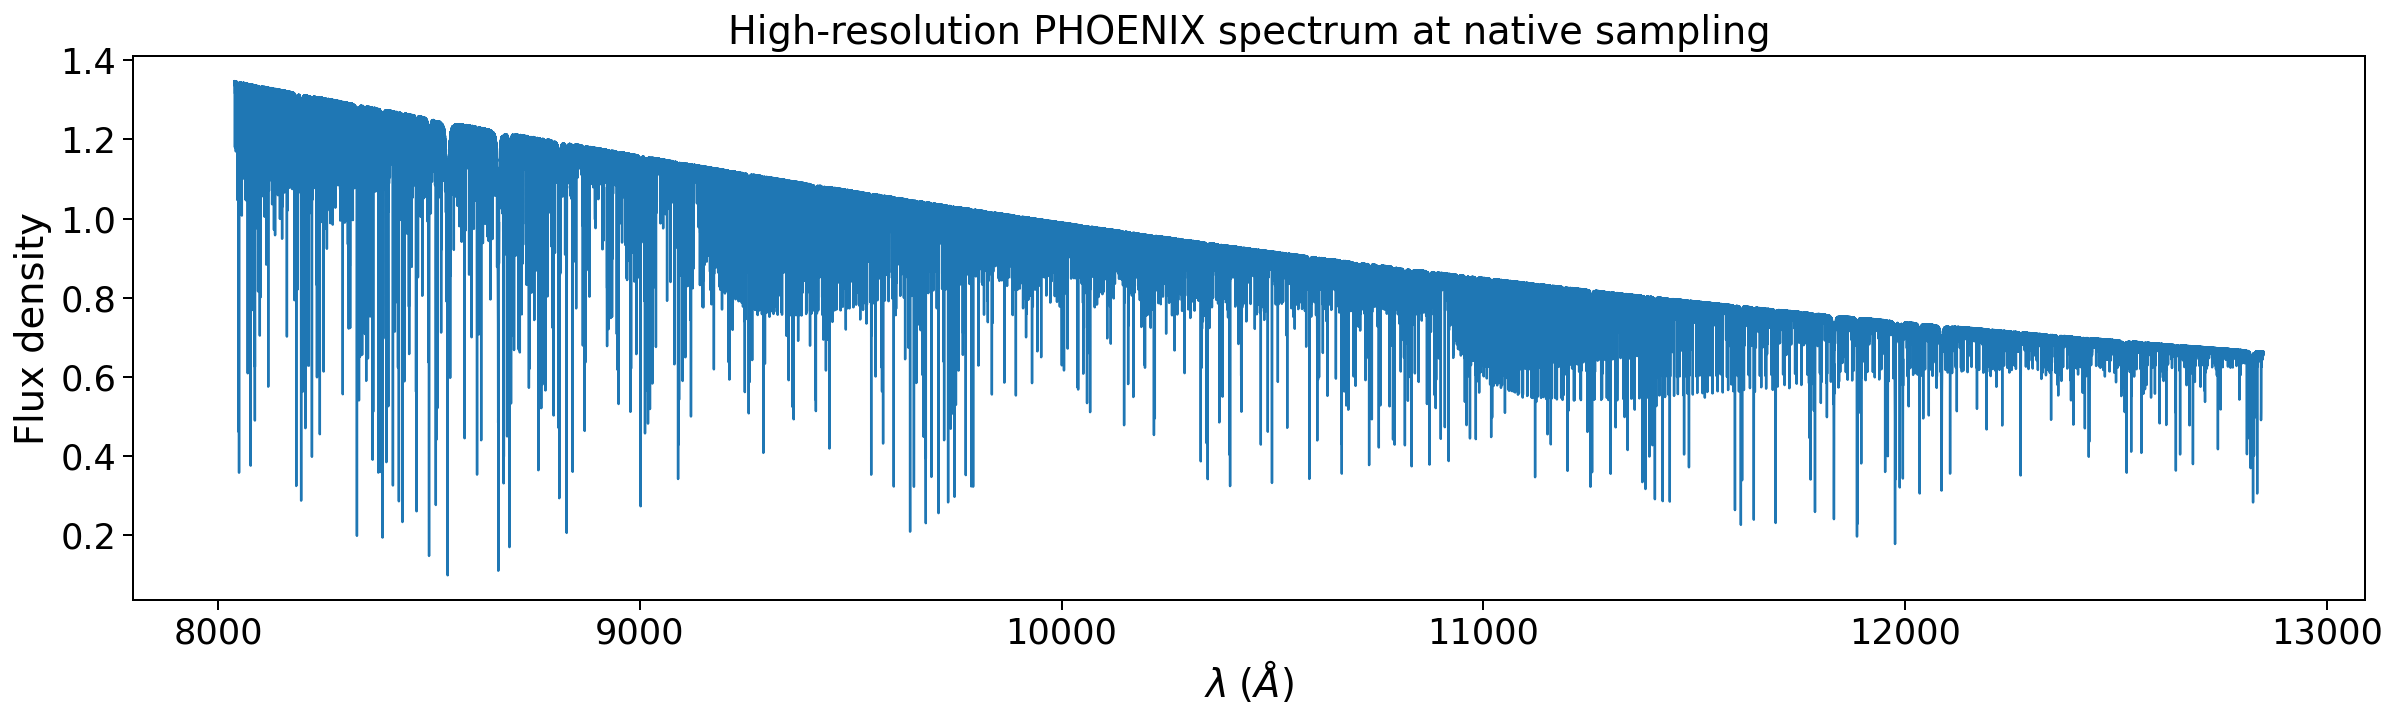

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(model.wl_native, model.flux_native)
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Flux density')
plt.title('High-resolution PHOENIX spectrum at native sampling');

Our goal is to clone *most* of those lines.

In [6]:
smoothed_flux = gaussian_filter1d(model.flux_native.cpu(), sigma=10.0)

In [7]:
peaks, _ = find_peaks(-smoothed_flux, distance=10, prominence=0.05)

(8660.0, 8680.0)

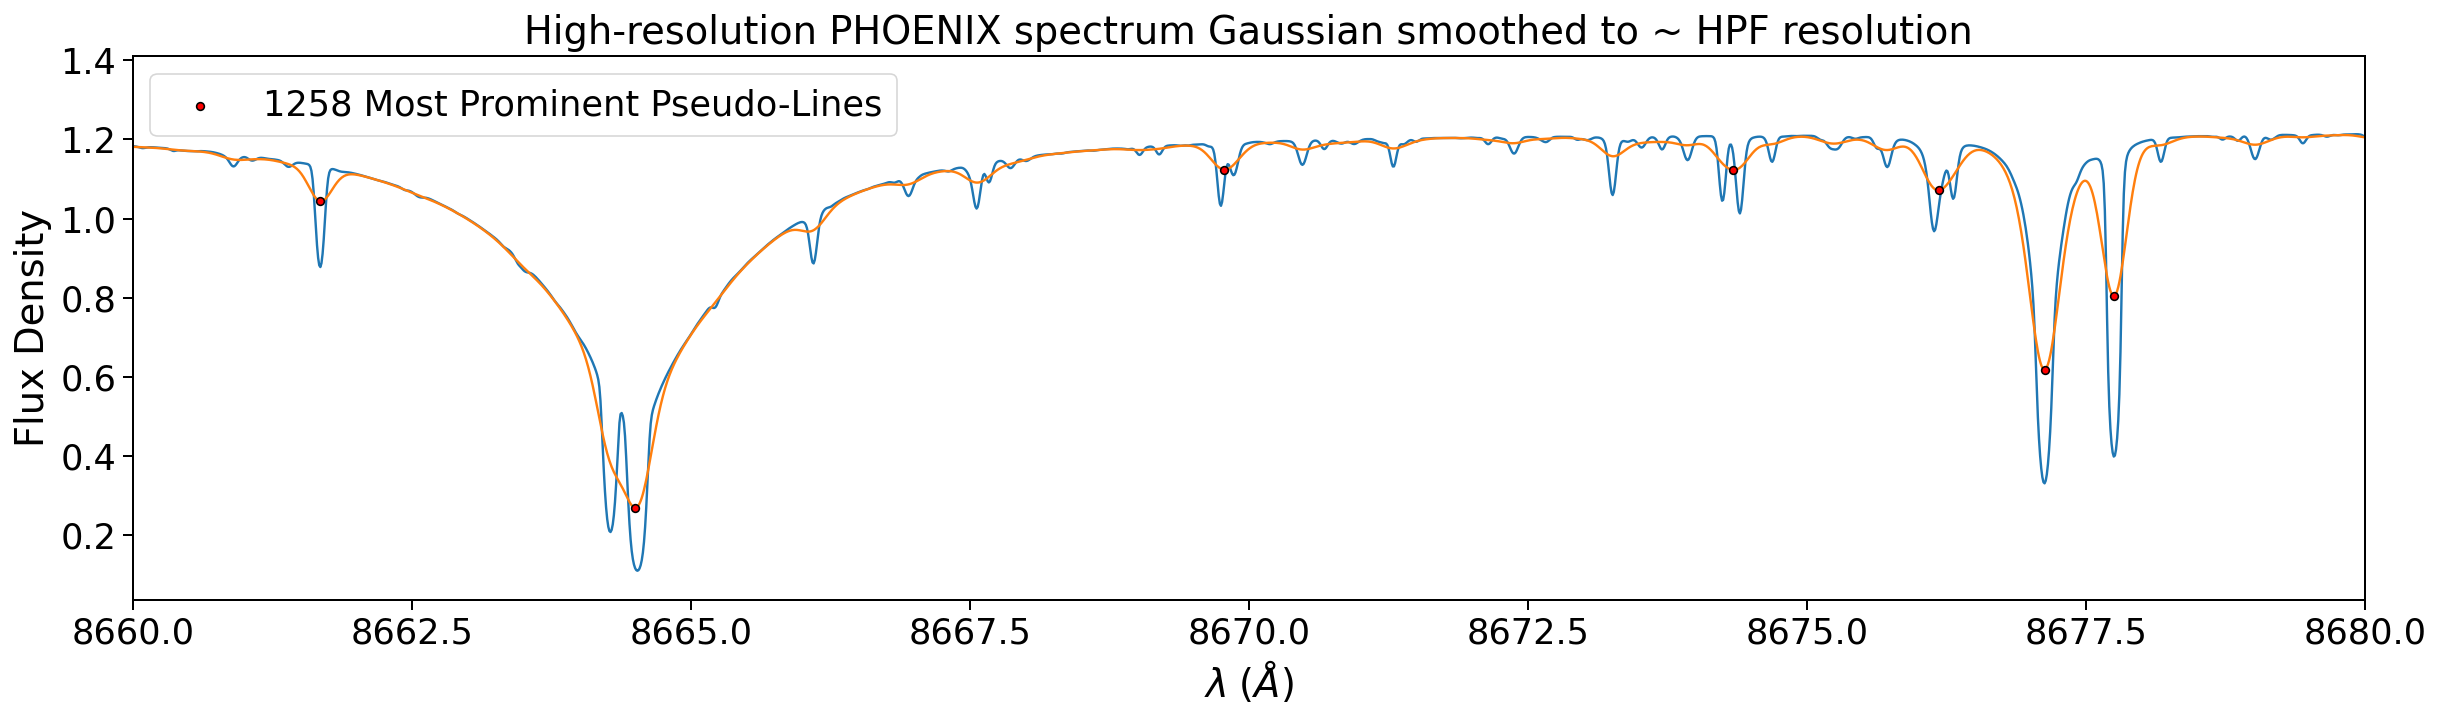

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(model.wl_native, model.flux_native)
plt.plot(model.wl_native, smoothed_flux)
plt.scatter(model.wl_native[peaks], smoothed_flux[peaks], marker='o', fc='r',ec='k', zorder=10, s=15,
         label='{:} Most Prominent Pseudo-Lines'.format(len(peaks)))
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Flux Density')
plt.title('High-resolution PHOENIX spectrum Gaussian smoothed to ~ HPF resolution')
plt.legend();
plt.xlim(8660, 8680)

Ok, so we can probably reconstruct a decent predictive model of the spectrum with "only" ~1000 lines.

In [9]:
prominence_data = peak_prominences(-smoothed_flux, peaks)
width_data = peak_widths(-smoothed_flux, peaks, prominence_data=prominence_data)

In [10]:
prominences, left, right = prominence_data
widths, width_heights, left_ips, right_ips = width_data

Let's spot-check against real data to ensure that the cloned model resembles reality, even if coarsely.

In [11]:
wl = data.data_cube[6, 5, :]
flux = data.data_cube[0, 5, :]

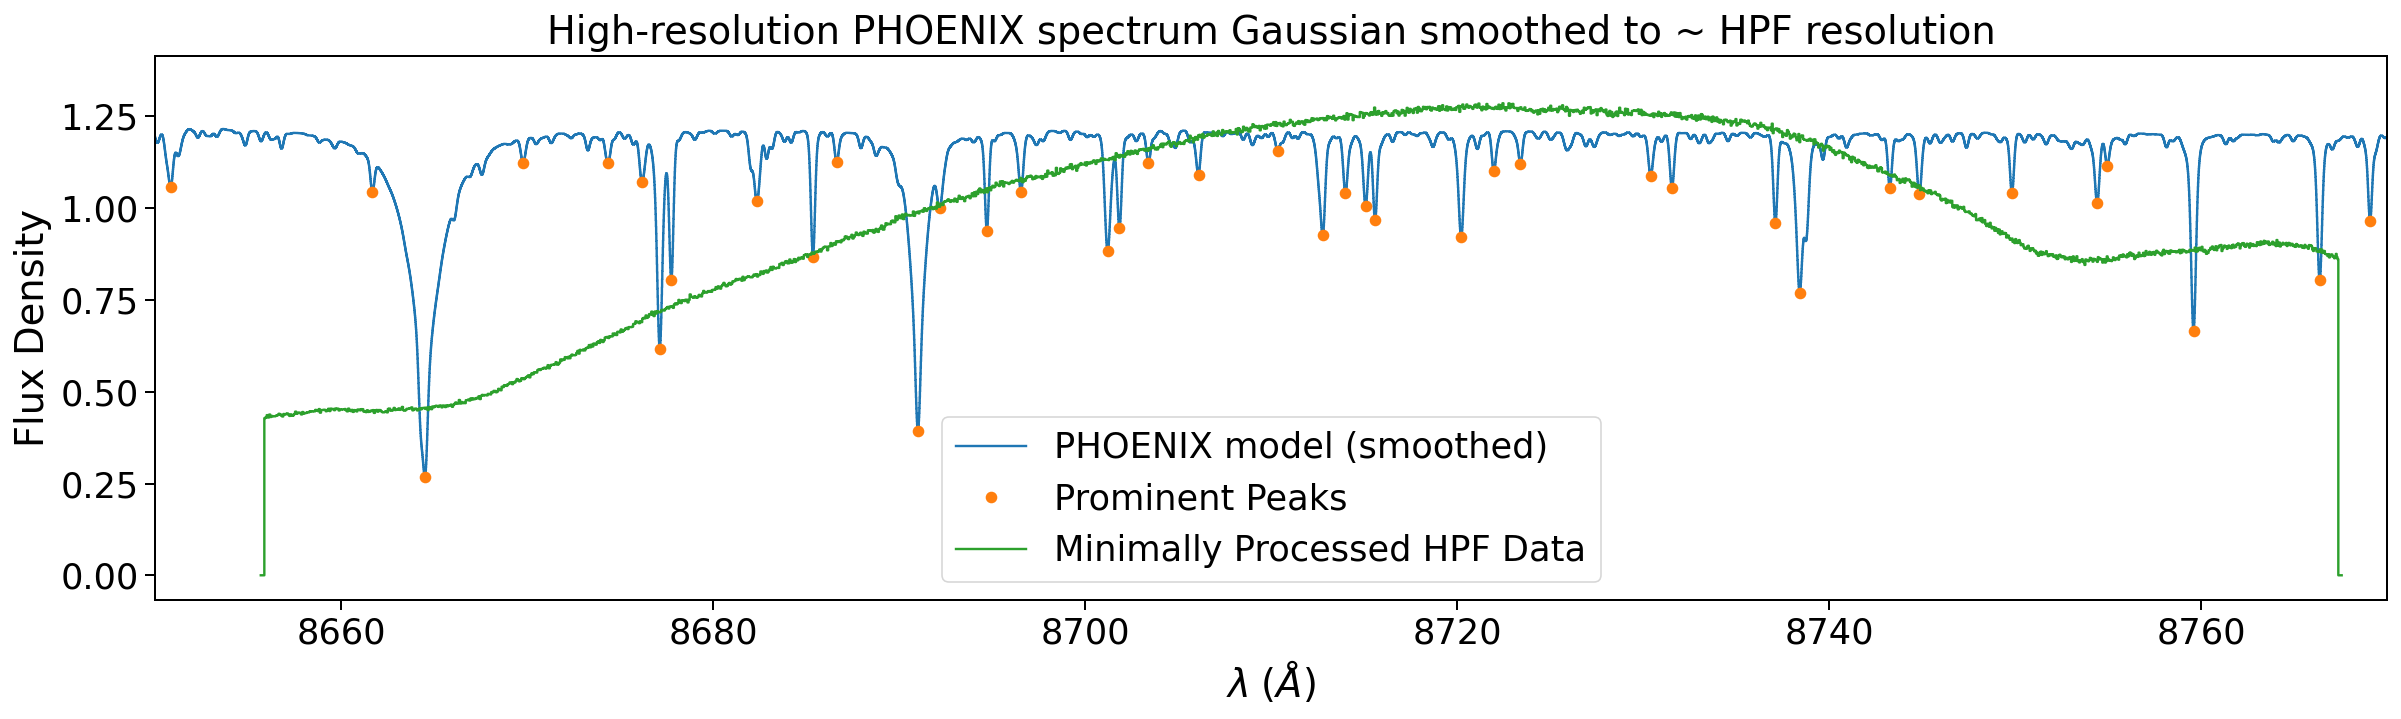

In [12]:
plt.figure(figsize=(20, 5))
plt.step(model.wl_native, smoothed_flux, label='PHOENIX model (smoothed)')
plt.step(model.wl_native[peaks], smoothed_flux[peaks], 'o', label='Prominent Peaks')
plt.step(wl-0.5, flux, label='Minimally Processed HPF Data')
plt.xlim(8650, 8770);
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Flux Density')
plt.title('High-resolution PHOENIX spectrum Gaussian smoothed to ~ HPF resolution')
plt.legend();

Awesome! We can replicate most of the structure seen in real data, if only the line strengths (and widths) were slightly different.  That's our goal (eventually)!  In the meantime, we need a function that takes in the signal-processed metadata and returns a decent initial guess.

In [13]:
def lorentzian_line(lam_center, width, amplitude, wavelengths):
    '''Return a Lorentzian line, given properties'''
    return amplitude/3.141592654 * width/(width**2 + (wavelengths - lam_center)**2)

In [14]:
def gaussian_line(lam_center, width, amplitude, wavelengths):
    '''Return a Gaussian line, given properties'''
    return amplitude/(width*torch.sqrt(torch.tensor(2*3.14159))) * torch.exp(-0.5*((wavelengths - lam_center) / width)**2)

In [15]:
lam_centers = model.wl_native[peaks]

Convert the FWHM in units of Angstroms: $$\sigma(Angstroms) = FWHM\frac{pixels}{1} \times \frac{Angstrom}{pixel} \times \frac{1}{2.355}$$

In [16]:
d_lam = np.diff(model.wl_native.cpu())[peaks]
widths_angs = torch.tensor(widths * d_lam / 2.355) * 0.83804203 *0.77116# Experimentally determined

The prominence scale factor may not be exactly 1.

In [17]:
prominence_scale_factor = 0.461*0.55736 # Experimentally determined
amplitudes = torch.tensor(prominences * prominence_scale_factor)

In [18]:
%%time
output = gaussian_line(lam_centers.unsqueeze(1), 
                          widths_angs.unsqueeze(1), 
                          amplitudes.unsqueeze(1), model.wl_native.unsqueeze(0))

CPU times: user 13.8 s, sys: 5.92 s, total: 19.7 s
Wall time: 3.77 s


In [19]:
%%time
output = lorentzian_line(lam_centers.unsqueeze(1), 
                          widths_angs.unsqueeze(1), 
                          amplitudes.unsqueeze(1), model.wl_native.unsqueeze(0))

CPU times: user 4.7 s, sys: 3.81 s, total: 8.51 s
Wall time: 1.42 s


In [20]:
output.shape

torch.Size([1258, 338624])

## What about Voigts?

In [21]:
from torch.special import erfc

def erfcx_naive(x):
    """Erfcx based on erfc"""
    return torch.exp(x*x) * erfc(x)

try:
    from torch.special import erfcx
    print('Woohoo! You have a new version of PyTorch')
except ImportError:
    erfcx = erfcx_naive

Woohoo! You have a new version of PyTorch


In [22]:
from scipy.special import erfcx as scipy_erfcx

In [23]:
vals = torch.arange(-2, 100.0, 0.1)

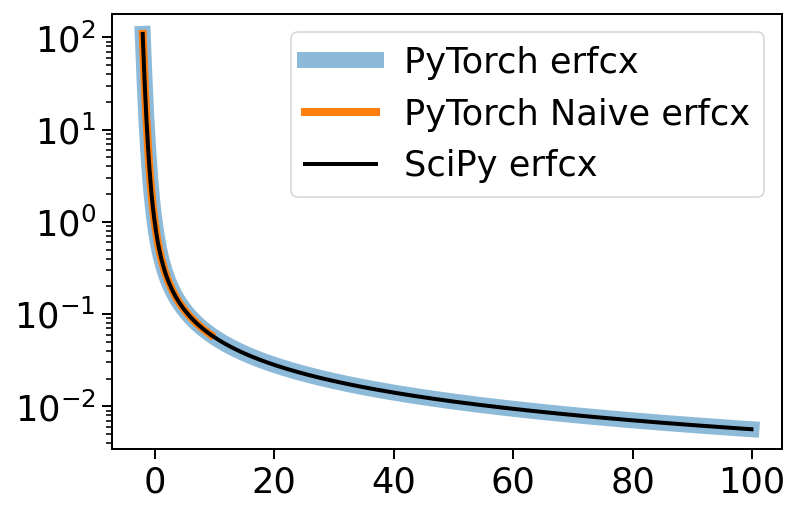

In [24]:
plt.plot(vals, erfcx(vals), label='PyTorch erfcx', lw=8, alpha=0.5)
plt.plot(vals, erfcx_naive(vals), label='PyTorch Naive erfcx', lw=4)
plt.plot(vals, scipy_erfcx(vals), label='SciPy erfcx', lw=2, color='k')

plt.legend()
plt.yscale('log')

In [25]:
torch.__version__

'1.11.0.dev20211008'

We should use PyTorch 1.11 and higher to get better numerical stability.

In [26]:
import math

In [27]:
from scipy.special import wofz

In [28]:
an=torch.tensor([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ,10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5])

a2n2=torch.tensor([  0.25,   1.  ,   2.25,   4.  ,   6.25,   9.  ,  12.25, 16.  ,  20.25,  25.  ,  30.25,  36.  ,  42.25,  49.  ,56.25,  64.  ,  72.25,  81.  ,  90.25, 100.  , 110.25, 121.  , 132.25, 144.  , 156.25, 169.  , 182.25])

In [29]:
an = an.unsqueeze(0).unsqueeze(1)
a2n2 = a2n2.unsqueeze(0).unsqueeze(1)

In [30]:
an.shape

torch.Size([1, 1, 27])

Ported from exoJAX to PyTorch.  The terms are:

$x = \frac{\lambda}{\sqrt(2)\beta}$

$a = \frac{\gamma_L}{\sqrt(2)\beta}$

In [39]:
x_term.shape

torch.Size([1258, 338624, 1])

In [31]:
betas = widths_angs.unsqueeze(1)

In [38]:
betas.shape

torch.Size([1258, 1])

In [32]:
x_term = model.wl_native.unsqueeze(0) / (math.sqrt(2) * betas)

In [33]:
gamma_L = 1.5*torch.ones_like(betas)

In [34]:
a_term = gamma_L / (math.sqrt(2) * betas)

In [35]:
x_term = x_term.unsqueeze(2)

In [37]:
x_term.shape

torch.Size([1258, 338624, 1])

In [52]:
a_term = a_term.unsqueeze(1)
a_term.shape

torch.Size([1258, 1, 1])

### A Tensor of shape (1258, 338624, 27) is too big.

We have a few options:

- Use a supercomputer/GPU with more RAM
- Use minibatches of lines or wavelengths
- Use sparse tensors

In [53]:
x_term.squeeze().shape

torch.Size([1258, 338624])

In [54]:
def rewofz(x,y):
    """Real part of wofz (Faddeeva) function based on Algorithm 916
    
    We apply a=0.5 for Algorithm 916.  
    Ported from exojax to PyTorch by gully    
    
    Args:
        x: Torch tensor
    Must be shape (N_lines x N_wl x  1)
        y: Torch tensor
    Must be shape (N_lines x 1 x 1)
        
    Returns:
         Torch tensor:
         (N_wl x N_lines)
    """
    xy = x*y
    exx = torch.exp(-1.0*x*x)
    f = exx * (erfcx(y) * torch.cos(2.0*xy) + x*torch.sin(xy)/math.pi*torch.sinc(xy/math.pi))
    y2=y**2
    Sigma23=torch.sum((torch.exp(-(an+x)**2)+torch.exp(-(an-x)**2))/(a2n2+y2), axis=2)       
    Sigma1=exx*(7.78800786e-01/(0.25+y2)+3.67879450e-01/(1.+y2)+1.05399221e-01/(2.25+y2)+1.83156393e-02/(4.+y2)+1.93045416e-03/(6.25+y2)+1.23409802e-04/(9.+y2)+4.78511765e-06/(12.25+y2)+1.12535176e-07/(16.+y2))
    f = f + y/math.pi*(-1*torch.cos(2.0*xy)*Sigma1 + 0.5*Sigma23.unsqueeze(1))
    return f

In [55]:
rewofz(x_term, a_term)

RuntimeError: [enforce fail at CPUAllocator.cpp:68] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 92013622272 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
vec = torch.arange(-35.0, 35.0, 0.2).unsqueeze(1)
vec2 = 1.2*torch.ones_like(vec)

In [ ]:
vec_sc = vec.numpy()
vec2_sc = vec2.numpy()

In [ ]:
rewofz(vec, vec2).shape

In [ ]:
plt.step(vec, rewofz(vec, vec2), lw=4, label='PyTorch')
plt.step(vec_sc, wofz(vec_sc + 1j*vec2_sc).real, label='SciPy')
plt.legend()
plt.axvline(np.sqrt(111-vec2[0]**2), color='k', linestyle='dashed')
plt.axvline(-1*np.sqrt(111-vec2[0]**2), color='k', linestyle='dashed')
plt.yscale('log')
plt.ylim(1e-4, 1e0)